# Fitting a 2D Gaussian Tensor Train model to toy data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import scipy
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfm = tf.math

# setup path for repo imports
import sys, os
sys.path.append('../')

## Import Toy data

In [2]:
from data import gen_8gaussians, to_tf_dataset

# Number of datapoints to generate
N = 10000
batch_size = 64

# Generate toy data
data = gen_8gaussians(batch_size=N)

# Reserve some data for testing
x_val = data[-1000:]
x_train = data[:-1000]

# Prepare the datasets
ds_train = to_tf_dataset(x_train, batch_size=batch_size)
ds_val  = to_tf_dataset(x_val, batch_size=batch_size)

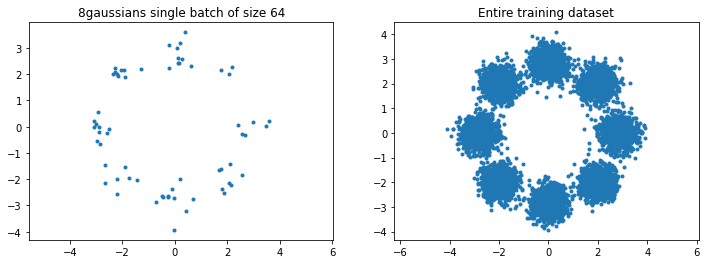

In [3]:
# Plot a single batch of the train dataset
single_batch = list(ds_train)[0]
f, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(single_batch[:, 0], single_batch[:, 1], '.')
ax[0].axis('equal')
ax[0].set_title(f'8gaussians single batch of size {batch_size}')
ax[1].plot(x_train[:, 0], x_train[:, 1], '.')
ax[1].axis('equal')
ax[1].set_title(f'Entire training dataset')
plt.show()

## Fit model to data

In [4]:
from models import TensorTrainGaussian2D

In [5]:
# create model
K = 4
model = TensorTrainGaussian2D(K)

# Instantiate an optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

In [ ]:
# Fit the model
EPOCHS = 20
# tf.config.run_functions_eagerly(True) # try to add this if you get an error
for epoch in range(EPOCHS):
    
    # Iterate over the batches of the dataset
    for i, x in enumerate(ds_train):
        loss_value = model.train_step(x, optimizer)

    print(
        "Training loss of last batch of epoch %d: %.4f"
        % (epoch, float(loss_value))
    )

    # INSERT SOME KIND OF VALIDATION LOOP

In [ ]:
# Set number of points and limits
n_points = 1000
lim = 4

# create probability map
x, dx = np.linspace(-lim, lim, n_points, retstep=True)
y, dy = np.linspace(-lim, lim, n_points, retstep=True)
x_grid, y_grid = np.meshgrid(x, y)
X = np.array([x_grid.ravel(), y_grid.ravel()]).T
# probabilities
p_log = model(X).numpy()
p = np.exp(p_log)

        
# Show density
plt.imshow(
    p.reshape(n_points,n_points),
    extent=(-lim, lim, -lim, lim),
    origin='lower'
)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Likelihood')
plt.plot()
plt.show()


integrand = np.sum(p)*dx*dy
print(f'Density integrates to {round(integrand, 4)}')
print('It should be = 1.0')